# Homework 15

Section 11.1

Math 404

Winter 2020

Logan Schelly

In [1]:
import numpy as np
import sympy as sy
from matplotlib import pyplot as plt

## Exercise 11.2
Code up a GMM sampler: your code should accept positive integers $K$ and $N$, nonnegative weights $w_1, \ldots, w_K$, vectors $\mathbf{\mu}_1, \ldots, \mathbf{\mu}_K \in \mathbb{R}^d$, and positive definite matrices $\Sigma_1, \dots, \Sigma_k \in M_{d\times d}$.  It should return $N$ draws $\mathbf{x}_1, \ldots, \mathbf{x}_N \in \mathbb{R}^d$ from the Gaussian mixture model with p.d.f. $f(\mathbf{x}) = \frac{1}{W}\sum_{k=1}^{K}w_k f_k(\mathbf{x})$ where $W = \sum_{k=1}^{K}w_k$ (so that $\sum_{k=1}^{K}\frac{w_k}{W} =1$).  Use vectorization rather than for-loops whenever possible.

In [2]:
class GMMSampler:
    
    def __init__(self, weights, mus, sigmas):
        """
        GMM sampler is a class for sampling from a GMM.
        
        Parameters
        ----------
        weights : array-like of shape (K,)
            weights[i] gives the relative probability of drawing from
            mixture i.  Weights must be non-negative, but are not required
            to sum to 1.
            
        mus : array-like of shape (K,d)
            mus[i,:] represents the mean of the ith Gaussian distribution.
            
        sigmas : array-like of shape(K,d,d)
            sigmas[i] represents the covariance matrix of the ith Gaussian distribution.
        """
        w = np.array(weights)
        assert np.all(w>=0) #non-negativity.
        self.pi = w / w.sum()
        
        K = self.pi.size
        
        self.mu = np.array(mus)
        assert self.mu.shape[0] == K
        
        d = self.mu.shape[1]
        
        self.sigma = np.array(sigma)
        assert self.sigma.shape[1:] == (d,d)
        
        return
    
    def sample(self, n):
        '''
        Draw n samples from the Gaussian mixture model.
        
        Parameters
        ----------
        n : int, non-negative
            The number of samples to draw.
            
        Returns
        X : array of shape (n, d)
            The samples drawn. 'd' represents the size of the means passed in to the constructor.
        '''
        d = self.mu.shape[1]
        K = self.mu.shape[0]
        
        #Make a draw from the categorical latent random variable.
        y = np.random.choice(K, size=n,p=self.pi)
        
        #Use the latent variable to determine which distribution we
        #use to draw for x.
        X = np.empty((n,d))
        for category in range(K):
            mask = (y == category)
            Nc = mask.sum()
            mu = self.mu[category]
            sigma = self.sigma[category]
            X[mask, :] = np.random.multivariate_normal(mu, sigma, size=Nc)

        return X

In [3]:
#Test this by setting up 4 categories in R^2.
K = 4
d = 2
mu = np.empty((K,d))
sigma = np.empty((K, d, d))

#top-right should be highly positively correlated cluster.
mu[0] = np.array((4,4))
sigma[0] = np.array([
    [1,.9],
    [.9,1]
])
#top left quadrant should have a highly negatively correlated cluster.
mu[1] = np.array((-4,4))
sigma[1] = np.array([
    [1,-.9],
    [-.9,1]
])
#bottom left should have very little variance & be uncorrelated.
mu[2] = np.array((-4,-4))
sigma[2] = np.array([
    [.1, 0],
    [0, .1]
])
#bottom right should have a lot of variance, especially in the x direction,
#and still be uncorrelated. (enough variance to bleed across axes.)
mu[3] = np.array((4, -4))
sigma[3] = np.array([
    [4, 0],
    [0, 2]
])

#make bottom right twice as likely as
#top right, which will be twice as likely as top left,
#which will be twice as likely as bottom left.
weights = [4, 2, 1, 8]

myGMM = GMMSampler(weights, mu, sigma)

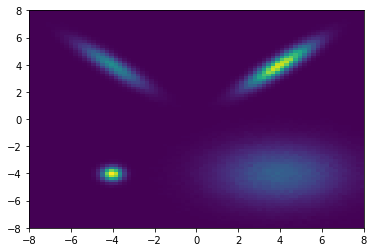

In [4]:
#Draw a ton of samples and plot.

samps = myGMM.sample(10**6)
plt.hist2d(samps[:,0], samps[:,1], bins=100)
plt.xlim(-8, 8)
plt.ylim(-8,8)
plt.show()

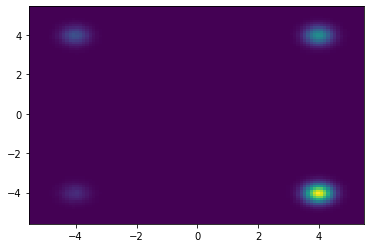

In [5]:
#Yep, looks like it's working.
#Now, give them all the same covariance and run again to make sure the weights isn't being distributed evenly.
sigma[:,:,:] = sigma[2]
myGMM = GMMSampler(weights, mu, sigma)

samps = myGMM.sample(10**6)
plt.hist2d(samps[:,0], samps[:,1], bins=100)
plt.show()

Looks good!

## Exercise 11.3

Latent variables: (burglar or earthquake)->house alarm
Observed variables: neighbor M or neighbor J calls you about your alarm going off.

In [6]:
#Probability of burglary.
PB = sy.Rational(2, 1000)

#Probability of Earthquake
PE = sy.Rational(1, 1000)

#Conditional probability of alarm given earthquake/burglar
#Column represents no/yes for earthquake.
#Row represents no/yes for burglar.
PAgivenBE = sy.Matrix([
    [sy.Rational(1, 1000), sy.Rational(29, 100)],
    [sy.Rational(94, 100), sy.Rational(95, 100)]
])
#^Note: The copy of the homework had typos.  I assumed P(E|B,E) was supposed to be P(A|B,E)

#Conditional Probability of neighbor J or M calling given Alarm.
#Entry 0 is no alarm.  Entry 1 is alarm.
PJgivenA = sy.Matrix([sy.Rational(5,100), sy.Rational(9, 10)])
PMgivenA = sy.Matrix([sy.Rational(1, 100), sy.Rational(7, 10)])
#^Note: The copy handed out in class had typos.  I assume the second P(M|A=1) was supposed to be P(M|A=0).

### Part (i)
Turned in with written portion.

### Part (ii)
Compute the following probabilities:

#### (a) $P(J=1)$

In [7]:
#Find PA.  I assume B and E are independent.
#Use the law of total probability conditioned on (B,E)
PA = (PAgivenBE[0,0]*(1-PB)*(1-PE)
      +PAgivenBE[0,1]*(1-PB)*(PE)
      +PAgivenBE[1,0]*(PB)*(1-PE)
      +PAgivenBE[1,1]*PB*PE)

#Now condition on A to find P(J=1)
PJ = PJgivenA[0]*(1-PA) + PJgivenA[1]*PA
print("P(J=1) =", PJ)
print("That's {} in decimal.".format(float(PJ)))

P(J=1) = 526914757/10000000000
That's 0.0526914757 in decimal.


---
#### (b) $P(J=1|B=1)$

In [8]:
#P(J=1|B=1) = sum over a P(J=1|A=a)*P(A=a|B=1)
#Find P(A=a|B) by chain rule and matrix multplication.
PAgivenB = PAgivenBE * sy.Matrix([
                        [1-PE],
                        [PE]
])
#First entry is given B=0, second is given B=1.
print(PAgivenB)

Matrix([[1289/1000000], [94001/100000]])


In [9]:
PJgivenB = PJgivenA[0]*(1-PAgivenB[1]) + PJgivenA[1]*PAgivenB[1]
#Funny thought: You're actually really lucky in P(J=1|A=0)*P(A=0|B=1).
#A burglar comes.  The alarm doesn't go off.
#Your neighbor THINKS they hear the alarm, and calls you.  You lucky dog.
print("P(J=1|B=1) = ",PJgivenB)
print("That's {} in decimal.".format(float(PJgivenB)))

P(J=1|B=1) =  1698017/2000000
That's 0.8490085 in decimal.


---
#### (c) $P(B=1|J=1,M=0)$
By Baye's rule,
$$
P(B=1|J=1,M=0) = \frac{P(J=1,M=0|B=1)P(B=1)}{P(J=1,M=0)}
$$
I assume $J$ and $M$ are independent random variables when conditioned on A because the neighbors do not know eachother and they do not interact.  This implies that
$$
P(J, M | B) =  \sum_{a=0}^{1}P(J, M| B, A=a) P(A=a|B) \quad\text{by LOTP}\\
= \sum_{a=0}^{1}P(J, M| A=a) P(A=a|B) \quad\text{because A is the parent.}\\
= \sum_{a=0}^1 P(J|A=a) P(M|A=a) P(A=a|B)
$$

In [10]:
PJ1M0givenB = (PJgivenA[0] * (1-PMgivenA[0]) * (1-PAgivenB[1])
               +PJgivenA[1] * (1-PMgivenA[1]) * PAgivenB[1])

This also implies 
$$
P(J, M) = \sum_{a=0}^{1} P(J, M|A=a)P(A=a) 
$$
by LOTP.

In [11]:
PJ1M0 = (PJgivenA[0] * (1-PMgivenA[0]) * (1-PA)
               +PJgivenA[1] * (1-PMgivenA[1]) * PA)

We now substitute into our expression for Bayes' rule for our formula.

In [12]:
PBgivenJ1M0 = PJ1M0givenB * PB / PJ1M0
print("P(B=1|J=1,M=0) =", PBgivenJ1M0)
print("That's {} in decimal.".format(float(PBgivenJ1M0)))

P(B=1|J=1,M=0) = 57060490/5577577829
That's 0.010230335057508347 in decimal.


---
#### (d) $P(E=1|A=1)$
Use Baye's Rule.
$$
P(E=1|A=1) = \frac{P(A=1|E=1)P(E=1)}{P(A=1)}
$$
Compute $P(A=1|E=1)$ with the law of total probability, conditioning on B.

In [13]:
#Find P(A=a|E) by chain rule and matrix multplication.
PAgivenE = sy.Matrix([1-PB, PB]).T * PAgivenBE
#First entry is given E=0, second is given E=1.
print(PAgivenE)

Matrix([[1439/500000, 7283/25000]])


In [14]:
PEgivenA = PAgivenE[1] * PE / PA
print("P(E=1|A=1) =", PEgivenA)
print("That's {} in decimal.".format(float(PEgivenA)))

P(E=1|A=1) = 145660/1583221
That's 0.09200231679594953 in decimal.


#### (e) $P(B=1|A=1)$
Use the same approach as in part (d).

In [15]:
PBgivenA = PAgivenB[1] * PB / PA
print("P(B=1|A=1) =", PBgivenA)
print("That's {} in decimal.".format(float(PBgivenA)))

P(B=1|A=1) = 940010/1583221
That's 0.5937326500848586 in decimal.


---
#### (f) P(E=1, B=1 | A=1)
We want to use Bayes' rule again.
$$
P(E=1, B=1 | A=1)
=
\frac{P(A=1|E=1,B=1)P(E=1, B=1)}{P(A=1)}
$$
Since neither $E$ nor $B$ have parents in our model, they are independent without conditioning, so we can factor their joint probability.
$$
P(E=1, B=1 | A=1)
=
\frac{P(A=1|E=1,B=1)P(E=1)P(B=1)}{P(A=1)}
$$

In [16]:
PE1B1givenA1 = PAgivenBE[1,1] * PE * PB / PA
print("P(E=1,B=1|A=1) =", PE1B1givenA1)
print("That's {} in decimal.".format(float(PE1B1givenA1)))

P(E=1,B=1|A=1) = 950/1583221
That's 0.0006000425714413844 in decimal.


In [17]:
print(float(PEgivenA * PBgivenA))

0.054624779365205815


---
### Part (iii)

What do the last three probability computations say about the conditional independence of $E$ and $B$ given $A$?

*Since $P(E|A)P(B|A) \neq P(E,B|A)$, $E$ and $B$ are not independent given $A$*.

---
### Part (iv)
Why does this not require an edge between $B$ and $E$ in the DGM?

*Edges keep track of child/parent relationships. $B$ is not $E$'s parent, and $E$ is not $B$'s parent.  The path ($B \rightarrow A \leftarrow E$) already encapsulates their dependence when conditioned on $A$.*